In [2]:
import os,sys
curr_path = os.getcwd()
sys.path.append('../../codes')
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import datetime
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

import torch
from itertools import count
import gym
from agent import Agent
# from memory import ReplayBuffer,NaivePrioritizedBuffer,NStepReplayBuffer
from common.plot import plot_rewards
from common.utils import save_results,make_dir

# multi-envs + 1 agent

In [3]:
from common.atari_wrappers import make_atari, wrap_deepmind, wrap_pytorch
import tianshou as ts
from common.multiprocessing_env import SubprocVecEnv
# from replay_buffer import PrioritizedReplayBuffer

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# !pip install box2d-py # for box2d envs
def make_env(env_id,seed=1):
    if 'Pong' in env_id:
        env = make_atari(env_id)
        env = wrap_deepmind(env,episode_life=True)
        env = wrap_pytorch(env) 
    else:
        env = gym.make(env_id)
    if seed: env.seed(seed)
    return env
def init_envs_agent(cfg,nenv,seed=1):
    envs = ts.env.ShmemVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
#     envs = ts.env.SubprocVectorEnv([lambda: make_env(cfg.env_id,seed) for _ in range(nenv)])
    if len(envs.observation_space[0].shape) == 1:
        state_dim = envs.observation_space[0].shape[0]
    else:
        state_dim = envs.observation_space[0].shape
        
    if 'Continuous' in cfg.model:
        cfg.max_act = envs.action_space[0].high[0]
        action_dim = envs.action_space[0].shape[0]
    else:
        action_dim = envs.action_space[0].n
        
    agent = Agent(state_dim,action_dim,cfg)
    return envs,agent
    
#<ImageToPyTorch<ClipRewardEnv<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>

In [5]:
def train(cfg,envs,agent):
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    envs.seed(cfg.seed)
    
    print('Start Training!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames'],history['loss']  = [],[],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_train_env),np.zeros(cfg.n_train_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0
    buffer = []

    states = envs.reset()
    while i_frame < cfg.max_train_frames: #1500000: #
        
        ### interactive with environments ###
        for _ in range(cfg.n_multi_step):
            values, dists, actions = agent.sample(states)
            #if cfg.n_train_env == 1: actions = [actions]
            #actions = np.random.randint(6,size=cfg.n_train_env)
            next_states,rewards,dones,infos = envs.step(actions.cpu().detach().numpy())
            eps_rewards += rewards
            done_envs_ids = np.where(dones)[0]
            eps_frames += 1
            _states = torch.as_tensor(states, device=cfg.device, dtype=torch.float32)
            rewards = torch.as_tensor(rewards,device=cfg.device, dtype=torch.float32).unsqueeze(1)
            dones = torch.as_tensor(np.float32(dones), device=cfg.device).unsqueeze(1)
            buffer.append((_states ,values, dists, actions, rewards, dones))
            states = next_states
            i_frame += len(actions)
            
            ### recording historys ###
            if len(done_envs_ids) > 0:
                for r in eps_rewards[done_envs_ids]:
                    history['rewards'].append(r)
                    if history['ma_rewards']:
                        history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                    else:
                        history['ma_rewards'].append(r)
                for n in eps_frames[done_envs_ids]:
                    if history['frames']:
                        history['frames'].append(history['frames'][-1] + n)
                    else:
                        history['frames'].append(n)
                eps_frames[done_envs_ids] = 0
                eps_rewards[done_envs_ids] = 0
                states[done_envs_ids] = envs.reset(done_envs_ids)
        
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 1000:
                prev_frame_verbose = history['frames'][-1]
                if history['loss']:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}: Loss:{history['loss'][-1]:.4f}")
                else:
                    print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
            if history['frames'][-1] - prev_frame_save >= cfg.max_train_frames//10:
                prev_frame_save = history['frames'][-1]
                make_dir(cfg.result_path,cfg.model_path+time)
                agent.save(path=cfg.model_path+time+'/')
                
        ### updating agent ###
        loss = agent.learn(buffer,next_states)
        if loss:
            history['loss'].append(loss)
        del buffer[:]
                    
    make_dir(cfg.result_path,cfg.model_path+time)
    agent.save(path=cfg.model_path+time+'/')
    return history

In [6]:
def evaluate(cfg,envs,agent,render=False):
    envs.seed(1)
    print('Start Evaluating!')
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    print(time)

    history = {}
    history['rewards'], history['ma_rewards'],history['frames']  = [],[],[]
    eps_frames,eps_rewards = np.zeros(cfg.n_eval_env),np.zeros(cfg.n_eval_env)
    i_frame,prev_frame = 0,0
    prev_frame_verbose, prev_frame_save = -1000,0

    states = envs.reset()
    while i_frame < cfg.max_eval_frames:
        ### interactive with environments ###
        if render: envs.render()
        _,dist = agent.predict(states)
        actions = dist.sample()
        if cfg.n_eval_env == 1: actions = [actions]
        next_states,rewards,dones,infos = envs.step(actions.cpu().detach().numpy())
        eps_rewards += rewards
        done_envs_ids = np.where(dones)[0]
        eps_frames += 1
        states = next_states
        i_frame += len(actions)

        ### recording historys ###
        if len(done_envs_ids) > 0:
            for r in eps_rewards[done_envs_ids]:
                history['rewards'].append(r)
                if history['ma_rewards']:
                    history['ma_rewards'].append(history['ma_rewards'][-1]*0.9+r*0.1)
                else:
                    history['ma_rewards'].append(r)
            for n in eps_frames[done_envs_ids]:
                if history['frames']:
                    history['frames'].append(history['frames'][-1] + n)
                else:
                    history['frames'].append(n)
            eps_frames[done_envs_ids] = 0
            eps_rewards[done_envs_ids] = 0
            states[done_envs_ids] = envs.reset(done_envs_ids)
            
        ### verbose ###
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        if history['frames']:
            if history['frames'][-1] - prev_frame_verbose >= 10:
                prev_frame_verbose = history['frames'][-1]
                print(f"[{time}: {cfg.agent}] Episode:{len(history['frames'])}: Frame:{history['frames'][-1]}: Reward:{history['rewards'][-1]:.1f}")
    return history

In [7]:
def main():
    cfg = config()
    print(cfg.agent,cfg.env_id)
    
    envs,agent = init_envs_agent(cfg,cfg.n_train_env)
    history = train(cfg,envs,agent)
    make_dir(cfg.result_path,cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(history,tag='train',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="train",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

    eval_envs,agent = init_envs_agent(cfg,cfg.n_eval_env,seed=10)
    agent.load(path=cfg.model_path)
    history = evaluate(cfg,eval_envs,agent,render=False)
    save_results(history,tag='eval',path=cfg.result_path)
    plot_rewards(history['rewards'],history['ma_rewards'],tag="eval",env=cfg.env_id,algo = cfg.agent,path=cfg.result_path)

# CartPole-v0

In [17]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'PPO'             # name of agent
        self.env_id = 'CartPole-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 3e5     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.n_ppo_epochs = 4          # number of learning epochs from same buffer
        self.mini_batch_size = 64       # sample size for one learning update
        self.ratio_clip_epsilon = 0.2   # epsilon for PPO clip
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0001                 # learning rate
        self.gamma = 0.97              # discount rate of reward
        self.n_multi_step = 6          # number of steps of multi-step style gain 
        self.model = 'Discrete_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

PPO CartPole-v0
Start Training!
20210806-154136
[20210806-154137: PPO] Episode:5: Frame:53.0: Reward:12.0: Loss:0.0778
[20210806-154137: PPO] Episode:64: Frame:1100.0: Reward:16.0: Loss:-0.0863
[20210806-154138: PPO] Episode:122: Frame:2243.0: Reward:16.0: Loss:0.1329
[20210806-154139: PPO] Episode:185: Frame:3272.0: Reward:11.0: Loss:0.4385
[20210806-154140: PPO] Episode:248: Frame:4357.0: Reward:13.0: Loss:1.3576
[20210806-154141: PPO] Episode:312: Frame:5452.0: Reward:14.0: Loss:1.9640
[20210806-154142: PPO] Episode:380: Frame:6515.0: Reward:10.0: Loss:5.4646
[20210806-154142: PPO] Episode:441: Frame:7539.0: Reward:22.0: Loss:3.9922
[20210806-154143: PPO] Episode:505: Frame:8606.0: Reward:24.0: Loss:3.4894
[20210806-154144: PPO] Episode:571: Frame:9653.0: Reward:17.0: Loss:2.1894
[20210806-154145: PPO] Episode:630: Frame:10703.0: Reward:30.0: Loss:0.4142
[20210806-154146: PPO] Episode:675: Frame:11729.0: Reward:16.0: Loss:0.8471
[20210806-154147: PPO] Episode:715: Frame:12783.0: Rew

[20210806-154250: PPO] Episode:1492: Frame:117858.0: Reward:131.0: Loss:4.6251
[20210806-154251: PPO] Episode:1498: Frame:118925.0: Reward:183.0: Loss:1.7150
[20210806-154252: PPO] Episode:1505: Frame:120033.0: Reward:149.0: Loss:-0.3621
[20210806-154252: PPO] Episode:1513: Frame:121451.0: Reward:194.0: Loss:-0.1675
[20210806-154253: PPO] Episode:1520: Frame:122572.0: Reward:155.0: Loss:0.3021
[20210806-154254: PPO] Episode:1528: Frame:123660.0: Reward:151.0: Loss:2.6848
[20210806-154255: PPO] Episode:1535: Frame:124771.0: Reward:161.0: Loss:1.1370
[20210806-154255: PPO] Episode:1542: Frame:125786.0: Reward:135.0: Loss:-0.1559
[20210806-154256: PPO] Episode:1550: Frame:126897.0: Reward:139.0: Loss:-0.4129
[20210806-154256: PPO] Episode:1557: Frame:127950.0: Reward:172.0: Loss:4.1437
[20210806-154257: PPO] Episode:1564: Frame:129097.0: Reward:178.0: Loss:-0.0739
[20210806-154258: PPO] Episode:1573: Frame:130575.0: Reward:170.0: Loss:-0.1035
[20210806-154259: PPO] Episode:1580: Frame:131

[20210806-154357: PPO] Episode:2153: Frame:233249.0: Reward:200.0: Loss:0.6856
[20210806-154358: PPO] Episode:2158: Frame:234249.0: Reward:200.0: Loss:10.7438
[20210806-154359: PPO] Episode:2163: Frame:235249.0: Reward:200.0: Loss:-0.2831
[20210806-154359: PPO] Episode:2169: Frame:236425.0: Reward:200.0: Loss:2.5506
[20210806-154400: PPO] Episode:2175: Frame:237509.0: Reward:200.0: Loss:-0.1919
[20210806-154400: PPO] Episode:2181: Frame:238576.0: Reward:145.0: Loss:-0.4068
[20210806-154401: PPO] Episode:2189: Frame:239707.0: Reward:147.0: Loss:-0.0195
[20210806-154401: PPO] Episode:2196: Frame:240737.0: Reward:183.0: Loss:1.5815
[20210806-154402: PPO] Episode:2203: Frame:241799.0: Reward:136.0: Loss:0.6118
[20210806-154402: PPO] Episode:2210: Frame:242906.0: Reward:195.0: Loss:1.0330
[20210806-154403: PPO] Episode:2217: Frame:244042.0: Reward:188.0: Loss:-0.0818
[20210806-154403: PPO] Episode:2224: Frame:245164.0: Reward:155.0: Loss:-0.1105
[20210806-154403: PPO] Episode:2230: Frame:24

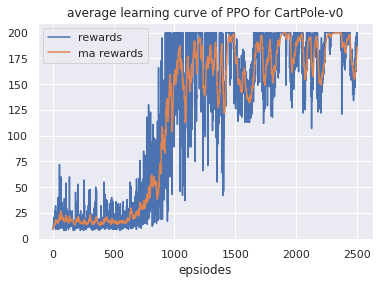

Start Evaluating!
20210806-154434
[20210806-154435: PPO] Episode:4: Frame:800.0: Reward:200.0
[20210806-154435: PPO] Episode:8: Frame:1600.0: Reward:200.0
[20210806-154435: PPO] Episode:12: Frame:2400.0: Reward:200.0
[20210806-154436: PPO] Episode:16: Frame:3200.0: Reward:200.0
[20210806-154436: PPO] Episode:20: Frame:4000.0: Reward:200.0
[20210806-154437: PPO] Episode:24: Frame:4800.0: Reward:200.0
[20210806-154437: PPO] Episode:28: Frame:5600.0: Reward:200.0
[20210806-154438: PPO] Episode:32: Frame:6400.0: Reward:200.0
[20210806-154438: PPO] Episode:36: Frame:7200.0: Reward:200.0
[20210806-154439: PPO] Episode:40: Frame:8000.0: Reward:200.0
[20210806-154439: PPO] Episode:44: Frame:8800.0: Reward:200.0
[20210806-154440: PPO] Episode:48: Frame:9600.0: Reward:200.0
results saved!


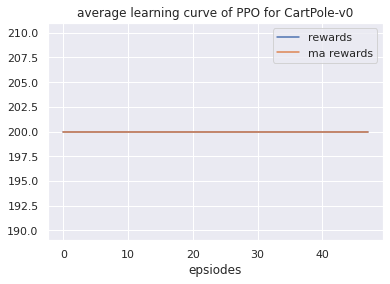

In [18]:
main()

# PongNoFrameskip-v4

In [31]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'PPO'             # name of agent
        self.env_id = 'PongNoFrameskip-v4'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.5e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames 
        self.n_ppo_epochs = 4          # number of learning epochs from same buffer
        self.mini_batch_size = 64       # sample size for one learning update
        self.ratio_clip_epsilon = 0.2   # epsilon for PPO clip
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0001                 # learning rate
        self.gamma = 0.98              # discount rate of reward
        self.n_multi_step = 45          # number of steps of multi-step style gain 
        self.model = 'Discrete_CNN'             # name of model
        self.hidden_dim = 512           # dimmension of hidden layer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

PPO PongNoFrameskip-v4
Start Training!
20210806-155127
[20210806-155139: PPO] Episode:4: Frame:3134.0: Reward:-21.0: Loss:0.0570
[20210806-155140: PPO] Episode:7: Frame:5580.0: Reward:-21.0: Loss:-0.1510
[20210806-155141: PPO] Episode:9: Frame:7354.0: Reward:-20.0: Loss:-0.0431
[20210806-155142: PPO] Episode:13: Frame:11197.0: Reward:-20.0: Loss:0.0511
[20210806-155143: PPO] Episode:15: Frame:13191.0: Reward:-19.0: Loss:-0.0283
[20210806-155144: PPO] Episode:16: Frame:14289.0: Reward:-20.0: Loss:0.0480
[20210806-155153: PPO] Episode:20: Frame:17971.0: Reward:-21.0: Loss:-0.0034
[20210806-155153: PPO] Episode:23: Frame:20823.0: Reward:-19.0: Loss:-0.1306
[20210806-155154: PPO] Episode:25: Frame:22658.0: Reward:-21.0: Loss:-0.0648
[20210806-155155: PPO] Episode:28: Frame:25279.0: Reward:-21.0: Loss:0.0446
[20210806-155156: PPO] Episode:29: Frame:26315.0: Reward:-19.0: Loss:0.1049
[20210806-155156: PPO] Episode:30: Frame:27350.0: Reward:-20.0: Loss:-0.0434
[20210806-155157: PPO] Episode:3

[20210806-155513: PPO] Episode:176: Frame:234049.0: Reward:-10.0: Loss:-0.1527
[20210806-155513: PPO] Episode:177: Frame:236428.0: Reward:-6.0: Loss:0.0166
[20210806-155514: PPO] Episode:178: Frame:238971.0: Reward:-4.0: Loss:0.0094
[20210806-155515: PPO] Episode:179: Frame:241526.0: Reward:-4.0: Loss:-0.1086
[20210806-155518: PPO] Episode:180: Frame:243927.0: Reward:-7.0: Loss:-0.0785
[20210806-155520: PPO] Episode:181: Frame:246657.0: Reward:-3.0: Loss:0.0010
[20210806-155523: PPO] Episode:183: Frame:251830.0: Reward:-4.0: Loss:0.0572
[20210806-155524: PPO] Episode:184: Frame:254628.0: Reward:1.0: Loss:0.0007
[20210806-155532: PPO] Episode:185: Frame:257569.0: Reward:-2.0: Loss:-0.0301
[20210806-155535: PPO] Episode:186: Frame:260320.0: Reward:-2.0: Loss:0.0675
[20210806-155538: PPO] Episode:187: Frame:263139.0: Reward:-4.0: Loss:0.0931
[20210806-155538: PPO] Episode:188: Frame:265833.0: Reward:-2.0: Loss:0.0024
[20210806-155546: PPO] Episode:189: Frame:268504.0: Reward:3.0: Loss:0.1

[20210806-155929: PPO] Episode:294: Frame:526301.0: Reward:15.0: Loss:0.0078
[20210806-155933: PPO] Episode:295: Frame:528944.0: Reward:13.0: Loss:0.0078
[20210806-155937: PPO] Episode:297: Frame:533902.0: Reward:5.0: Loss:0.0132
[20210806-155940: PPO] Episode:298: Frame:536471.0: Reward:13.0: Loss:0.0467
[20210806-155942: PPO] Episode:299: Frame:538158.0: Reward:20.0: Loss:0.0162
[20210806-155943: PPO] Episode:300: Frame:540538.0: Reward:9.0: Loss:-0.0090
[20210806-155944: PPO] Episode:301: Frame:542231.0: Reward:20.0: Loss:0.0376
[20210806-155945: PPO] Episode:302: Frame:544009.0: Reward:18.0: Loss:0.0920
[20210806-155948: PPO] Episode:304: Frame:548261.0: Reward:11.0: Loss:0.0018
[20210806-155950: PPO] Episode:305: Frame:550076.0: Reward:18.0: Loss:0.0052
[20210806-155954: PPO] Episode:306: Frame:551735.0: Reward:20.0: Loss:0.0007
[20210806-155956: PPO] Episode:307: Frame:553560.0: Reward:20.0: Loss:-0.0602
[20210806-155957: PPO] Episode:308: Frame:556437.0: Reward:11.0: Loss:0.0113

[20210806-160348: PPO] Episode:423: Frame:811973.0: Reward:20.0: Loss:0.0376
[20210806-160349: PPO] Episode:424: Frame:814727.0: Reward:15.0: Loss:0.0295
[20210806-160351: PPO] Episode:426: Frame:818579.0: Reward:19.0: Loss:-0.0077
[20210806-160353: PPO] Episode:427: Frame:821079.0: Reward:13.0: Loss:0.0073
[20210806-160354: PPO] Episode:429: Frame:825210.0: Reward:18.0: Loss:0.0372
[20210806-160357: PPO] Episode:430: Frame:827308.0: Reward:18.0: Loss:0.0222
[20210806-160404: PPO] Episode:431: Frame:829495.0: Reward:16.0: Loss:0.0398
[20210806-160408: PPO] Episode:432: Frame:831555.0: Reward:15.0: Loss:-0.0016
[20210806-160409: PPO] Episode:433: Frame:833695.0: Reward:19.0: Loss:0.0069
[20210806-160412: PPO] Episode:436: Frame:839741.0: Reward:17.0: Loss:-0.0032
[20210806-160413: PPO] Episode:437: Frame:841406.0: Reward:20.0: Loss:-0.0083
[20210806-160414: PPO] Episode:438: Frame:843707.0: Reward:15.0: Loss:0.0287
[20210806-160415: PPO] Episode:439: Frame:845569.0: Reward:17.0: Loss:0.

[20210806-160808: PPO] Episode:561: Frame:1093341.0: Reward:18.0: Loss:-0.0257
[20210806-160810: PPO] Episode:562: Frame:1096411.0: Reward:14.0: Loss:0.0229
[20210806-160811: PPO] Episode:563: Frame:1098070.0: Reward:20.0: Loss:-0.0039
[20210806-160813: PPO] Episode:564: Frame:1100779.0: Reward:16.0: Loss:-0.0114
[20210806-160816: PPO] Episode:565: Frame:1102443.0: Reward:20.0: Loss:-0.0132
[20210806-160817: PPO] Episode:566: Frame:1104969.0: Reward:19.0: Loss:-0.0143
[20210806-160818: PPO] Episode:567: Frame:1107780.0: Reward:14.0: Loss:0.0074
[20210806-160820: PPO] Episode:568: Frame:1109451.0: Reward:20.0: Loss:0.0076
[20210806-160822: PPO] Episode:569: Frame:1111118.0: Reward:20.0: Loss:0.0060
[20210806-160823: PPO] Episode:570: Frame:1113632.0: Reward:20.0: Loss:0.0048
[20210806-160824: PPO] Episode:572: Frame:1118658.0: Reward:20.0: Loss:-0.0067
[20210806-160830: PPO] Episode:573: Frame:1121174.0: Reward:20.0: Loss:0.0008
[20210806-160831: PPO] Episode:574: Frame:1124145.0: Rewar

[20210806-161143: PPO] Episode:678: Frame:1339839.0: Reward:18.0: Loss:0.0233
[20210806-161145: PPO] Episode:679: Frame:1341796.0: Reward:17.0: Loss:-0.0543
[20210806-161145: PPO] Episode:680: Frame:1343699.0: Reward:17.0: Loss:-0.0196
[20210806-161147: PPO] Episode:681: Frame:1345700.0: Reward:18.0: Loss:-0.0086
[20210806-161147: PPO] Episode:682: Frame:1347483.0: Reward:19.0: Loss:0.0439
[20210806-161149: PPO] Episode:683: Frame:1349151.0: Reward:20.0: Loss:0.0265
[20210806-161153: PPO] Episode:685: Frame:1353092.0: Reward:20.0: Loss:-0.0140
[20210806-161154: PPO] Episode:686: Frame:1355194.0: Reward:16.0: Loss:0.0228
[20210806-161155: PPO] Episode:687: Frame:1357134.0: Reward:18.0: Loss:-0.0211
[20210806-161158: PPO] Episode:688: Frame:1359004.0: Reward:19.0: Loss:-0.0487
[20210806-161204: PPO] Episode:690: Frame:1362653.0: Reward:18.0: Loss:-0.0051
[20210806-161204: PPO] Episode:691: Frame:1365040.0: Reward:13.0: Loss:0.0243
[20210806-161212: PPO] Episode:692: Frame:1366891.0: Rewa

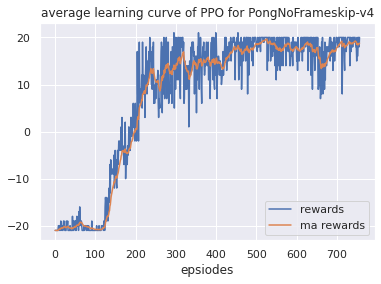

Start Evaluating!
20210806-161400
[20210806-161408: PPO] Episode:2: Frame:3324.0: Reward:20.0
[20210806-161408: PPO] Episode:3: Frame:4987.0: Reward:20.0
[20210806-161409: PPO] Episode:4: Frame:6732.0: Reward:20.0
[20210806-161417: PPO] Episode:5: Frame:8391.0: Reward:20.0
[20210806-161417: PPO] Episode:6: Frame:10133.0: Reward:20.0
[20210806-161418: PPO] Episode:7: Frame:11937.0: Reward:19.0
[20210806-161418: PPO] Episode:8: Frame:13679.0: Reward:20.0
[20210806-161425: PPO] Episode:9: Frame:15346.0: Reward:20.0
[20210806-161426: PPO] Episode:10: Frame:17008.0: Reward:20.0
[20210806-161426: PPO] Episode:11: Frame:18753.0: Reward:20.0
[20210806-161426: PPO] Episode:12: Frame:20420.0: Reward:20.0
[20210806-161433: PPO] Episode:13: Frame:22084.0: Reward:20.0
[20210806-161434: PPO] Episode:14: Frame:23746.0: Reward:20.0
[20210806-161434: PPO] Episode:15: Frame:25408.0: Reward:20.0
[20210806-161434: PPO] Episode:16: Frame:27154.0: Reward:20.0
[20210806-161441: PPO] Episode:17: Frame:28820.0

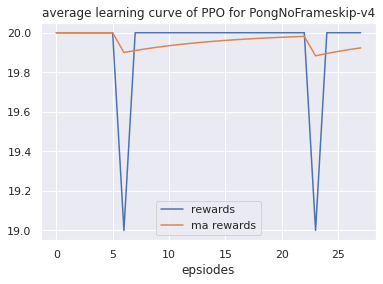

In [20]:
# 0.0001, 0.5 less samll variance, but more big variance
# 0.0001, 0.25
main()

# Pendulum-v0

In [38]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'PPO'             # name of agent
        self.env_id = 'Pendulum-v0'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1e6     # max number of training frames
        self.max_eval_frames = 1e4      # max number of evaluation frames
        self.n_ppo_epochs = 4          # number of learning epochs from same buffer
        self.mini_batch_size = 64       # sample size for one learning update
        self.ratio_clip_epsilon = 0.2   # epsilon for PPO clip
        self.w_critic_loss = 0.25         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0001                 # learning rate
        self.gamma = 0.90              # discount rate of reward
        self.n_multi_step = 16          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 2.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

PPO Pendulum-v0
Start Training!
20210807-145221
[20210807-145224: PPO] Episode:16: Frame:3200.0: Reward:-1817.1: Loss:387.9275
[20210807-145226: PPO] Episode:32: Frame:6400.0: Reward:-1294.5: Loss:174.7220
[20210807-145229: PPO] Episode:48: Frame:9600.0: Reward:-1206.2: Loss:98.7683
[20210807-145232: PPO] Episode:64: Frame:12800.0: Reward:-1497.7: Loss:35.0221
[20210807-145235: PPO] Episode:80: Frame:16000.0: Reward:-1384.9: Loss:55.0292
[20210807-145237: PPO] Episode:96: Frame:19200.0: Reward:-1447.7: Loss:22.2321
[20210807-145240: PPO] Episode:112: Frame:22400.0: Reward:-1522.0: Loss:10.4291
[20210807-145243: PPO] Episode:128: Frame:25600.0: Reward:-1549.0: Loss:20.0358
[20210807-145245: PPO] Episode:144: Frame:28800.0: Reward:-1559.8: Loss:14.1342
[20210807-145248: PPO] Episode:160: Frame:32000.0: Reward:-1428.9: Loss:23.6161
[20210807-145251: PPO] Episode:176: Frame:35200.0: Reward:-1489.0: Loss:5.2497
[20210807-145253: PPO] Episode:192: Frame:38400.0: Reward:-1078.3: Loss:15.9551


[20210807-145703: PPO] Episode:1664: Frame:332800.0: Reward:-261.4: Loss:0.0144
[20210807-145706: PPO] Episode:1680: Frame:336000.0: Reward:-623.8: Loss:0.0327
[20210807-145709: PPO] Episode:1696: Frame:339200.0: Reward:-254.0: Loss:-0.0707
[20210807-145711: PPO] Episode:1712: Frame:342400.0: Reward:-421.9: Loss:-0.0205
[20210807-145714: PPO] Episode:1728: Frame:345600.0: Reward:-271.2: Loss:-0.1933
[20210807-145717: PPO] Episode:1744: Frame:348800.0: Reward:-125.9: Loss:-0.1047
[20210807-145719: PPO] Episode:1760: Frame:352000.0: Reward:-249.7: Loss:-0.0328
[20210807-145722: PPO] Episode:1776: Frame:355200.0: Reward:-254.4: Loss:0.0746
[20210807-145725: PPO] Episode:1792: Frame:358400.0: Reward:-255.8: Loss:0.0097
[20210807-145728: PPO] Episode:1808: Frame:361600.0: Reward:-126.7: Loss:0.0597
[20210807-145730: PPO] Episode:1824: Frame:364800.0: Reward:-130.8: Loss:0.0002
[20210807-145733: PPO] Episode:1840: Frame:368000.0: Reward:-265.7: Loss:0.0136
[20210807-145736: PPO] Episode:1856

[20210807-150136: PPO] Episode:3312: Frame:662400.0: Reward:-128.9: Loss:-0.0040
[20210807-150139: PPO] Episode:3328: Frame:665600.0: Reward:-128.8: Loss:-0.0055
[20210807-150142: PPO] Episode:3344: Frame:668800.0: Reward:-129.1: Loss:-0.0010
[20210807-150144: PPO] Episode:3360: Frame:672000.0: Reward:-254.1: Loss:-0.0050
[20210807-150147: PPO] Episode:3376: Frame:675200.0: Reward:-1.2: Loss:0.0052
[20210807-150150: PPO] Episode:3392: Frame:678400.0: Reward:-133.9: Loss:-0.0092
[20210807-150153: PPO] Episode:3408: Frame:681600.0: Reward:-295.8: Loss:0.0030
[20210807-150155: PPO] Episode:3424: Frame:684800.0: Reward:-260.2: Loss:0.0022
[20210807-150158: PPO] Episode:3440: Frame:688000.0: Reward:-374.2: Loss:0.0033
[20210807-150201: PPO] Episode:3456: Frame:691200.0: Reward:-133.7: Loss:-0.0000
[20210807-150204: PPO] Episode:3472: Frame:694400.0: Reward:-129.0: Loss:0.0022
[20210807-150206: PPO] Episode:3488: Frame:697600.0: Reward:-376.8: Loss:0.0046
[20210807-150209: PPO] Episode:3504:

[20210807-150523: PPO] Episode:4944: Frame:988800.0: Reward:-128.7: Loss:0.0045
[20210807-150525: PPO] Episode:4960: Frame:992000.0: Reward:-262.2: Loss:-0.0026
[20210807-150527: PPO] Episode:4976: Frame:995200.0: Reward:-126.8: Loss:0.0092
[20210807-150528: PPO] Episode:4992: Frame:998400.0: Reward:-390.1: Loss:-0.0066
results saved!


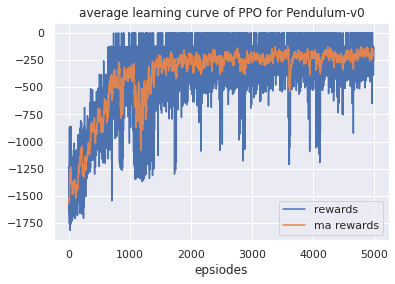

Start Evaluating!
20210807-150530
[20210807-150531: PPO] Episode:4: Frame:800.0: Reward:-129.0
[20210807-150531: PPO] Episode:8: Frame:1600.0: Reward:-129.7
[20210807-150532: PPO] Episode:12: Frame:2400.0: Reward:-130.3
[20210807-150532: PPO] Episode:16: Frame:3200.0: Reward:-259.9
[20210807-150533: PPO] Episode:20: Frame:4000.0: Reward:-132.4
[20210807-150534: PPO] Episode:24: Frame:4800.0: Reward:-128.6
[20210807-150534: PPO] Episode:28: Frame:5600.0: Reward:-374.1
[20210807-150535: PPO] Episode:32: Frame:6400.0: Reward:-1.1
[20210807-150535: PPO] Episode:36: Frame:7200.0: Reward:-131.8
[20210807-150536: PPO] Episode:40: Frame:8000.0: Reward:-0.6
[20210807-150536: PPO] Episode:44: Frame:8800.0: Reward:-128.4
[20210807-150537: PPO] Episode:48: Frame:9600.0: Reward:-424.7
results saved!


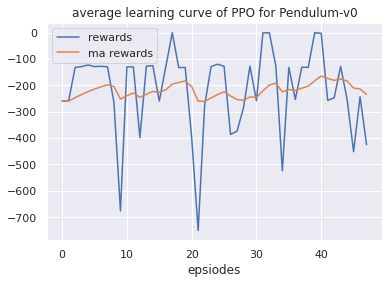

In [39]:
# 0.0001
main()

# LunarLanderContinuous-v2

In [22]:
class config:
    def __init__(self):
        self.seed = 1                         # seed
        self.agent = 'PPO'             # name of agent
        self.env_id = 'LunarLanderContinuous-v2'    # name of environment
        self.result_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_id+'/'+curr_time+'/'+self.agent+'/models/'  # path to save models
        self.n_train_env = 16           # number of training environment 
        self.n_eval_env = 4           # number of evaluation environment 
        self.max_train_frames = 1.5e6     # max number of training frames
        self.max_eval_frames = 5e4      # max number of evaluation frames
        self.n_ppo_epochs = 4          # number of learning epochs from same buffer
        self.mini_batch_size = 64       # sample size for one learning update
        self.ratio_clip_epsilon = 0.2   # epsilon for PPO clip
        self.w_critic_loss = 0.5         # weight of critic loss
        self.w_entropy_loss = 0.001      # weight of entropy loss
        self.lr = 0.0004                 # learning rate
        self.gamma = 0.98              # discount rate of reward
        self.n_multi_step = 1000          # number of steps of multi-step style gain 
        self.model = 'Continuous_MLP'             # name of model
        self.hidden_dim = 256           # dimmension of hidden layer
        self.max_act = 1.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check gpu

PPO LunarLanderContinuous-v2
Start Training!
20210809-113216
[20210809-113219: PPO] Episode:146: Frame:15182.0: Reward:-367.0
[20210809-113229: PPO] Episode:290: Frame:31096.0: Reward:-270.6: Loss:969.3988
[20210809-113239: PPO] Episode:422: Frame:47353.0: Reward:-156.9: Loss:519.1089
[20210809-113251: PPO] Episode:545: Frame:62730.0: Reward:-59.8: Loss:333.4736
[20210809-113303: PPO] Episode:663: Frame:78408.0: Reward:-34.7: Loss:137.1325
[20210809-113316: PPO] Episode:773: Frame:94251.0: Reward:-67.9: Loss:125.6717
[20210809-113328: PPO] Episode:863: Frame:109866.0: Reward:-39.2: Loss:143.4567
[20210809-113340: PPO] Episode:937: Frame:125348.0: Reward:-66.0: Loss:112.5545
[20210809-113352: PPO] Episode:979: Frame:139140.0: Reward:15.0: Loss:91.2414
[20210809-113406: PPO] Episode:999: Frame:153121.0: Reward:69.7: Loss:104.5947
[20210809-113420: PPO] Episode:1023: Frame:169121.0: Reward:119.5: Loss:119.9815
[20210809-113434: PPO] Episode:1047: Frame:182978.0: Reward:71.8: Loss:107.9991

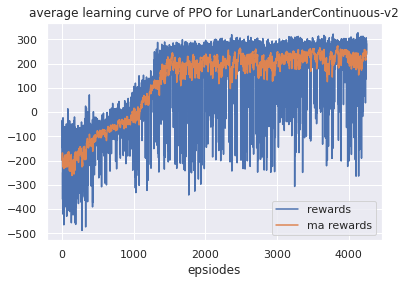

Start Evaluating!
20210809-115137
[20210809-115138: PPO] Episode:1: Frame:233.0: Reward:254.0
[20210809-115138: PPO] Episode:2: Frame:524.0: Reward:256.2
[20210809-115139: PPO] Episode:3: Frame:950.0: Reward:241.3
[20210809-115139: PPO] Episode:4: Frame:1201.0: Reward:241.4
[20210809-115139: PPO] Episode:5: Frame:1691.0: Reward:208.5
[20210809-115139: PPO] Episode:6: Frame:1912.0: Reward:298.6
[20210809-115139: PPO] Episode:7: Frame:2117.0: Reward:260.9
[20210809-115140: PPO] Episode:8: Frame:2314.0: Reward:270.2
[20210809-115140: PPO] Episode:9: Frame:2565.0: Reward:277.8
[20210809-115140: PPO] Episode:10: Frame:2739.0: Reward:244.7
[20210809-115140: PPO] Episode:11: Frame:2865.0: Reward:40.8
[20210809-115140: PPO] Episode:12: Frame:3144.0: Reward:297.7
[20210809-115140: PPO] Episode:13: Frame:3279.0: Reward:44.8
[20210809-115141: PPO] Episode:14: Frame:3470.0: Reward:254.6
[20210809-115141: PPO] Episode:15: Frame:3664.0: Reward:267.8
[20210809-115141: PPO] Episode:16: Frame:3854.0: R

[20210809-115215: PPO] Episode:133: Frame:39622.0: Reward:171.1
[20210809-115215: PPO] Episode:134: Frame:39862.0: Reward:284.3
[20210809-115216: PPO] Episode:135: Frame:39985.0: Reward:71.3
[20210809-115216: PPO] Episode:136: Frame:40617.0: Reward:165.8
[20210809-115216: PPO] Episode:137: Frame:40864.0: Reward:299.9
[20210809-115216: PPO] Episode:138: Frame:41064.0: Reward:286.0
[20210809-115218: PPO] Episode:139: Frame:41290.0: Reward:226.7
[20210809-115219: PPO] Episode:140: Frame:41489.0: Reward:284.3
[20210809-115219: PPO] Episode:141: Frame:42344.0: Reward:204.6
[20210809-115219: PPO] Episode:142: Frame:42760.0: Reward:233.1
[20210809-115219: PPO] Episode:143: Frame:43206.0: Reward:218.3
[20210809-115219: PPO] Episode:144: Frame:43388.0: Reward:246.0
[20210809-115219: PPO] Episode:145: Frame:43574.0: Reward:281.8
[20210809-115219: PPO] Episode:146: Frame:43748.0: Reward:43.1
[20210809-115219: PPO] Episode:147: Frame:43969.0: Reward:267.2
[20210809-115220: PPO] Episode:148: Frame:

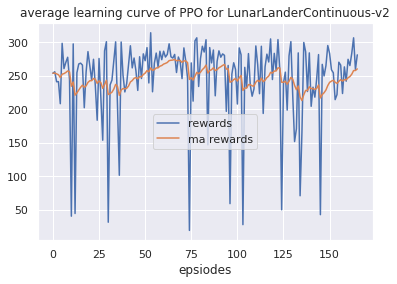

In [23]:
# 0.0004, 0.98,1000， 0.5
main()